# BC 3 Market Basket

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

April 2022

https://github.com/fpontejos/bc3


## Initial Setup

### Imports


In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil
from datetime import timedelta, datetime
import os
import re
import warnings
import itertools
import collections

warnings.filterwarnings('ignore')

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import is_color_like

from sklearn.feature_extraction import text


In [2]:
# pip install nltk
import nltk

## Uncomment these on first run
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer



In [3]:
# pip install networkx
import networkx as nx
from networkx.readwrite import json_graph

import json

import plotly.offline as py
import plotly.graph_objects as go

# pip install pydot
# pip install graphviz

import pydot
import graphviz

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


### Variables

In [4]:
COLORS = ['#e06666', '#e88b81', '#f0ad9a', '#f8ceb2', '#ffeeca', '#c6cfbf', '#8fb0ae', '#58919d', '#20718b']

CAT_COLORS = ['#20718b', '#7DB082', '#FAEC73', '#ECA052', '#e06666']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#e06666', '#e68d8d', '#ebb1b1', '#efd3d3', '#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

UMP_COLORS = ['#22446D', '#FC9E4F', '#AB2346' ,'#6ABB5D']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
CAT_PALETTE = sns.color_palette(CAT_COLORS)
UMP_PALETTE = sns.color_palette(UMP_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)
UMP_CMAP = LinearSegmentedColormap.from_list("ump_colors", UMP_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True
RANDOM_STATE = 9

IMG_PATH = 'imgs/'
DATA_PATH = '../data/'


In [5]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight', transparent=True)
        


In [6]:
## Function to plot histograms of numeric features for specified dfframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables", bins=10):
    if SHOW_PLOTS:
        cols = ceil(len(features) / rows)
        fig = plt.figure(figsize=(4*cols,4*rows),
                         constrained_layout=True)
        
        subfigs = fig.subfigures(rows, cols)
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(2, 1, sharex=True, \
                                gridspec_kw={'height_ratios': [4,1]})
        
            axs[0].hist(df[feat], color=COLORS[0], bins=bins)
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1, fontsize=6*rows)
        
            axs[1].set_xlabel(None)
            flierprops = dict(markerfacecolor='None', markersize=6,  markeredgecolor=COLORS[0])
            sns.boxplot(x=df[feat], ax=axs[1], color=COLORS[0], flierprops=flierprops)
            axs[1].set_xlabel(None)

            subf.suptitle(None)
        
        plt.suptitle(title, fontsize=8*rows)
        if SAVE_PLOTS:
            save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")

### Styles

In [7]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 128

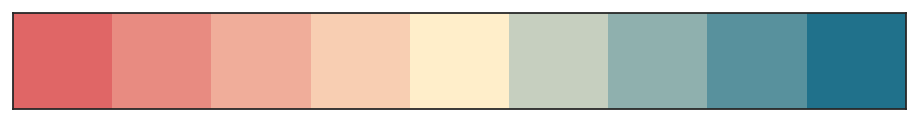

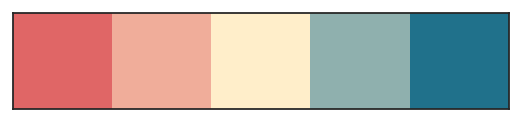

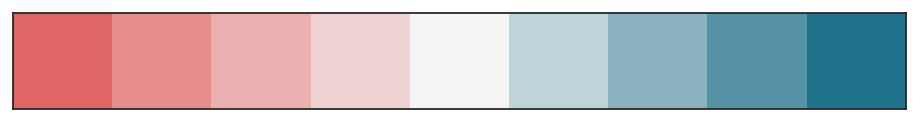

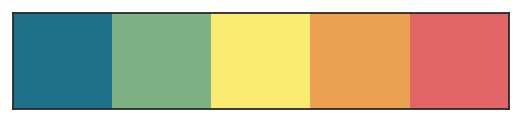

In [8]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Load df

In [9]:
df = pd.read_csv(DATA_PATH + "data_cleaned.csv")
df_orig = df.copy()

In [10]:
df.head()

InvoiceNo  Quantity  UnitPrice  Value  CustomerID          InvoiceDate  \
0    536365         6       2.55  15.30       17850  2010-12-01 08:26:00   
1    536365         6       3.39  20.34       17850  2010-12-01 08:26:00   
2    536365         8       2.75  22.00       17850  2010-12-01 08:26:00   
3    536365         6       3.39  20.34       17850  2010-12-01 08:26:00   
4    536365         6       3.39  20.34       17850  2010-12-01 08:26:00   

   IsCancelled                      Description  
0        False      hanging heart tlight holder  
1        False                    metal lantern  
2        False                heart coat hanger  
3        False  knitted union flag water bottle  
4        False                     woolly heart

In [11]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [12]:
df.dtypes

InvoiceNo              object
Quantity                int64
UnitPrice             float64
Value                 float64
CustomerID              int64
InvoiceDate    datetime64[ns]
IsCancelled              bool
Description            object
dtype: object

In [13]:
df_customer_types = pd.read_csv(DATA_PATH + 'customer_types.csv', index_col='CustomerID')
df_customer_types

Customer Type
CustomerID              
12346          Wholesale
12347          Wholesale
12348          Wholesale
12349          Wholesale
12350             Retail
...                  ...
18280             Retail
18281             Retail
18282          Wholesale
18283          Wholesale
18287          Wholesale

[4335 rows x 1 columns]

In [14]:
df = df.merge(df_customer_types, how='left', right_index=True, left_on='CustomerID')
df.rename(columns={'Customer Type': 'CustomerType'}, inplace=True)
df.head(3)

InvoiceNo  Quantity  UnitPrice  Value  CustomerID         InvoiceDate  \
0    536365         6       2.55  15.30       17850 2010-12-01 08:26:00   
1    536365         6       3.39  20.34       17850 2010-12-01 08:26:00   
2    536365         8       2.75  22.00       17850 2010-12-01 08:26:00   

   IsCancelled                  Description CustomerType  
0        False  hanging heart tlight holder    Wholesale  
1        False                metal lantern    Wholesale  
2        False            heart coat hanger    Wholesale

In [15]:
df_rt = df.loc[df['CustomerType']=='Retail']
df_ws = df.loc[df['CustomerType']=='Wholesale']

## Market Basket

In [16]:
def make_graph(G, pos, nodes):
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        text = "",
        textfont=dict(
            family="sans serif",
            size=10
        ),
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            reversescale=False,
            color=[],
            size=10,
            colorbar=dict(
                thickness=10,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=1))

    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append(f'{nodes[node]}: {str(len(adjacencies[1]))} connections')

    node_trace.marker.color = node_adjacencies
    node_trace.hovertext = node_text
    
    return edge_trace, node_trace
    
def make_figure(edge_trace, node_trace, title):
    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    title=title,
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002 ) ],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )


    fig.show()    
    
    

In [17]:
df_basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

In [18]:

df_basket_rt = df_rt.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
df_basket_ws = df_ws.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')


In [19]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [20]:
#df_basket_sets = df_basket.applymap(encode_units)

In [21]:
df_basket_sets_rt = df_basket_rt.applymap(encode_units)
df_basket_sets_ws = df_basket_ws.applymap(encode_units)

In [22]:
#df_basket_sets

In [23]:
frequent_itemsets_rt = apriori(df_basket_sets_rt, min_support=0.01, use_colnames=True)
frequent_itemsets_ws = apriori(df_basket_sets_ws, min_support=0.01, use_colnames=True)

In [24]:
frequent_itemsets_rt

support                                           itemsets
0    0.015171                         (aged glass tlight holder)
1    0.012010                          (airline bag vintage jet)
2    0.016435                        (airline bag vintage tokyo)
3    0.039191                             (alarm clock bakelike)
4    0.012642                           (alphabet exercise book)
..        ...                                                ...
652  0.010114  (cake baking case, time baking case, snack loa...
653  0.011378  (water bottle, heart water bottle, dog water b...
654  0.010114  (water bottle, dog water bottle, water bottle ...
655  0.015803  (star christmas scandinavian, heart christmas ...
656  0.011378  (snack loaf baking case, time baking case, min...

[657 rows x 2 columns]

In [25]:
frequent_itemsets_ws

support                                           itemsets
0    0.012543                         (aged glass tlight holder)
1    0.010956                        (airline bag vintage tokyo)
2    0.066531                             (alarm clock bakelike)
3    0.014476                           (alphabet exercise book)
4    0.011650                                     (antique hook)
..        ...                                                ...
746  0.012394  (lunch bag retrospot, lunch bag suki design, l...
747  0.012196  (lunch bag spaceboy design, lunch bag suki des...
748  0.010163  (lunch bag spaceboy design, lunch bag woodland...
749  0.010114  (lunch bag suki design, lunch bag woodland, lu...
750  0.010510  (lunch bag spaceboy design, lunch bag suki des...

[751 rows x 2 columns]

In [26]:
rules_rt = association_rules(frequent_itemsets_rt, metric="lift", min_threshold=1)
rules_rt

antecedents  \
0                                              (bag)   
1                                    (bag retrospot)   
2                                    (bag retrospot)   
3                                      (bag baroque)   
4                            (paper chain christmas)   
..                                               ...   
273  (snack loaf baking case, mini loaf baking case)   
274        (time baking case, mini loaf baking case)   
275                         (snack loaf baking case)   
276                               (time baking case)   
277                          (mini loaf baking case)   

                                         consequents  antecedent support  \
0                                    (bag retrospot)            0.037295   
1                                              (bag)            0.040455   
2                                      (bag baroque)            0.040455   
3                                    (bag retrospot)            0.020228   
4                                    (bag christmas)            0.051833   
..                                               ...                 ...   
273                               (time baking case)            0.015171   
274                         (snack loaf baking case)            0.013906   
275        (time baking case, mini loaf baking case)            0.020860   
276  (snack loaf baking case, mini loaf baking case)            0.024020   
277       (snack loaf baking case, time baking case)            0.024652   

     consequent support   support  confidence       lift  leverage  conviction  
0              0.040455  0.013906    0.372881   9.217161  0.012398    1.530085  
1              0.037295  0.013906    0.343750   9.217161  0.012398    1.466980  
2              0.020228  0.010114    0.250000  12.359375  0.009295    1.306363  
3              0.040455  0.010114    0.500000  12.359375  0.009295    1.919090  
4              0.027181  0.012642    0.243902   8.973341  0.011233    1.286632  
..                  ...       ...         ...        ...       ...         ...  
273            0.024020  0.011378    0.750000  31.223684  0.011014    3.903919  
274            0.020860  0.011378    0.818182  39.223140  0.011088    5.385272  
275            0.013906  0.011378    0.545455  39.223140  0.011088    2.169406  
276            0.015171  0.011378    0.473684  31.223684  0.011014    1.871176  
277            0.013906  0.011378    0.461538  33.188811  0.011035    1.831317  

[278 rows x 9 columns]

In [27]:
rules_rt_subs = association_rules(frequent_itemsets_rt, metric="support", )
rules_rt_subs.sort_values(by='lift', ascending=True)

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [28]:
rules_rt.to_csv(DATA_PATH + 'rules_retail.csv', index=False)

In [29]:
rules_ws = association_rules(frequent_itemsets_ws, metric="lift", min_threshold=1)
rules_ws

antecedents  \
0                             (alarm clock bakelike)   
1                                 (diner wall clock)   
2                             (alarm clock bakelike)   
3                           (regency cakestand tier)   
4                                     (bag alphabet)   
..                                               ...   
667  (lunch bag spaceboy design, lunch bag woodland)   
668      (lunch bag suki design, lunch bag woodland)   
669                      (lunch bag spaceboy design)   
670                          (lunch bag suki design)   
671                             (lunch bag woodland)   

                                           consequents  antecedent support  \
0                                   (diner wall clock)            0.066531   
1                               (alarm clock bakelike)            0.036438   
2                             (regency cakestand tier)            0.066531   
3                               (alarm clock bakelike)            0.077983   
4                                                (bag)            0.035348   
..                                                 ...                 ...   
667                            (lunch bag suki design)            0.019335   
668                        (lunch bag spaceboy design)            0.017500   
669        (lunch bag suki design, lunch bag woodland)            0.046403   
670    (lunch bag spaceboy design, lunch bag woodland)            0.049725   
671  (lunch bag spaceboy design, lunch bag suki des...            0.039314   

     consequent support   support  confidence       lift  leverage  conviction  
0              0.036438  0.012691    0.190760   5.235131  0.010267    1.190699  
1              0.066531  0.012691    0.348299   5.235131  0.010267    1.432358  
2              0.077983  0.011403    0.171386   2.197728  0.006214    1.112722  
3              0.066531  0.011403    0.146217   2.197728  0.006214    1.093333  
4              0.071538  0.017847    0.504909   7.057877  0.015319    1.875335  
..                  ...       ...         ...        ...       ...         ...  
667            0.049725  0.010510    0.543590  10.931953  0.009549    2.082064  
668            0.046403  0.010510    0.600567  12.942338  0.009698    2.387373  
669            0.017500  0.010510    0.226496  12.942338  0.009698    1.270193  
670            0.019335  0.010510    0.211366  10.931953  0.009549    1.243498  
671            0.021119  0.010510    0.267339  12.658449  0.009680    1.336062  

[672 rows x 9 columns]

In [30]:
rules_ws.to_csv(DATA_PATH + 'rules_wholesale.csv', index=False)

### Graph

In [31]:
df_invoices_rt = df_rt.loc[df_rt['CustomerID']!=0,:].groupby("InvoiceNo").agg(
    val_tot=pd.NamedAgg(column="Value", aggfunc="sum"),
    val_ave=pd.NamedAgg(column="Value", aggfunc="mean"),
    qty_tot=pd.NamedAgg(column="Quantity", aggfunc="sum"),
    qty_ave=pd.NamedAgg(column="Quantity", aggfunc="mean"),
    qty_count=pd.NamedAgg(column="Quantity", aggfunc="count"),
    last_purch=pd.NamedAgg(column="InvoiceDate", aggfunc="max"),
    CustomerID=pd.NamedAgg(column="CustomerID", aggfunc="max"),
    )

df_invoices_ws = df_ws.loc[df_ws['CustomerID']!=0,:].groupby("InvoiceNo").agg(
    val_tot=pd.NamedAgg(column="Value", aggfunc="sum"),
    val_ave=pd.NamedAgg(column="Value", aggfunc="mean"),
    qty_tot=pd.NamedAgg(column="Quantity", aggfunc="sum"),
    qty_ave=pd.NamedAgg(column="Quantity", aggfunc="mean"),
    qty_count=pd.NamedAgg(column="Quantity", aggfunc="count"),
    last_purch=pd.NamedAgg(column="InvoiceDate", aggfunc="max"),
    CustomerID=pd.NamedAgg(column="CustomerID", aggfunc="max"),
    )

In [32]:
df_inv_net_rt = df_invoices_rt.loc[df_invoices_rt['val_tot']>0].reset_index()
df_inv_net_ws = df_invoices_ws.loc[df_invoices_ws['val_tot']>0].reset_index()
#df_inv_net

In [33]:
inv_list_rt = df_inv_net_rt['InvoiceNo'].tolist()
inv_list_ws = df_inv_net_ws['InvoiceNo'].tolist()

In [34]:
paired_products_rt = []
paired_products_ws = []


In [35]:
df_small_rt = df_rt.loc[df_rt['Quantity']>0].groupby(['InvoiceNo', 'Description']).sum()['Quantity'].reset_index()
df_small_ws = df_ws.loc[df_ws['Quantity']>0].groupby(['InvoiceNo', 'Description']).sum()['Quantity'].reset_index()

#df_small_ws

In [36]:
#df['Description']

In [37]:
for order_id in df_inv_net_rt['InvoiceNo']:
    tmp_df_r = df_small_rt[df_small_rt['InvoiceNo'] == order_id]
    paired_products_rt.extend(list(itertools.combinations(tmp_df_r.iloc[:, 1], 2)))

counts_small_rt = collections.Counter(paired_products_rt)

df_counts_small_rt = pd.DataFrame(counts_small_rt.most_common(1000),
                      columns = ['products', 'counts'])


In [38]:
for order_id in df_inv_net_ws['InvoiceNo']:
    tmp_df_w = df_small_ws[df_small_ws['InvoiceNo'] == order_id]
    paired_products_ws.extend(list(itertools.combinations(tmp_df_w.iloc[:, 1], 2)))
    
counts_small_ws = collections.Counter(paired_products_ws)

df_counts_small_ws = pd.DataFrame(counts_small_ws.most_common(1000),
                      columns = ['products', 'counts'])



In [39]:
#df_counts_small_ws
#df_small_ws

In [40]:
#paired_products_ws

In [41]:
d_rt = df_counts_small_rt.set_index('products').T.to_dict('records')
d_ws = df_counts_small_ws.set_index('products').T.to_dict('records')

In [42]:
# Create and populate the graph object
G_rt = nx.Graph()

for key, val in d_rt[0].items():
    G_rt.add_edge(key[0], key[1], weight = val)

# Get the nodes for plotting the graph below
nodes_rt = [node for node in G_rt.nodes()]

# Get the node layout

pos_rt = nx.spring_layout(G_rt, k=5, weight='weight')
#pos_rt = nx.nx_pydot.graphviz_layout(G_rt, prog="neato")


In [43]:
json_rt = json_graph.node_link_data(G_rt)
with open(DATA_PATH + 'nxdump_rt.json', 'w') as fp:
    json.dump(json_rt, fp)

In [44]:
# Create and populate the graph object
G_ws = nx.Graph()

for key, val in d_ws[0].items():
    G_ws.add_edge(key[0], key[1], weight = val)


# Get the nodes for plotting the graph below
nodes_ws = [node for node in G_ws.nodes()]

# Get the node layout

pos_ws = nx.spring_layout(G_ws, k=5, weight='weight')
#pos_ws = nx.nx_pydot.graphviz_layout(G_ws, prog="neato")


In [45]:
json_ws = json_graph.node_link_data(G_ws)
with open(DATA_PATH + 'nxdump_ws.json', 'w') as fp:
    json.dump(json_ws, fp)

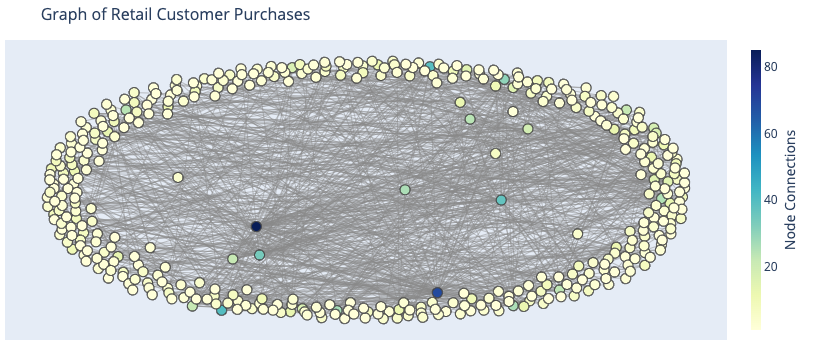

In [46]:
edge_trace_rt, node_trace_rt = make_graph(G_rt, pos_rt, nodes_rt)
make_figure(edge_trace_rt, node_trace_rt, "Graph of Retail Customer Purchases")

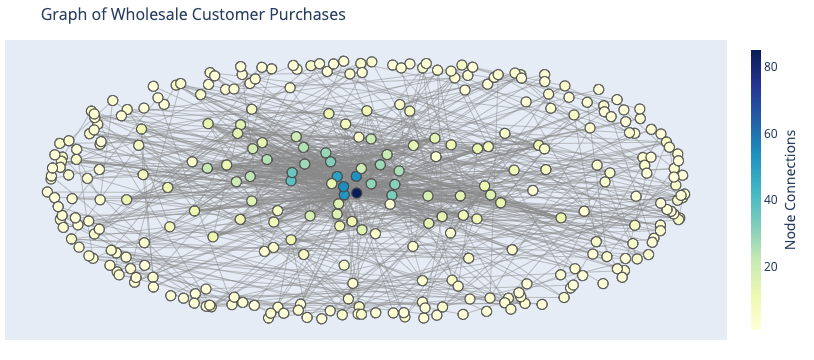

In [47]:
edge_trace_ws, node_trace_ws = make_graph(G_ws, pos_ws, nodes_ws)
make_figure(edge_trace_ws, node_trace_ws, "Graph of Wholesale Customer Purchases")

In [48]:
def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

In [49]:
nxload_rt = read_json_file(DATA_PATH + 'nxdump_rt.json')
nxload_rt

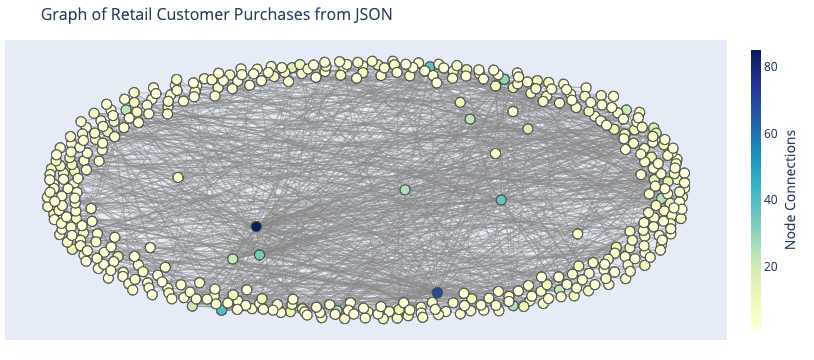

In [50]:
edge_trace_rt_, node_trace_rt_ = make_graph(nxload_rt, pos_rt, nodes_rt)
make_figure(edge_trace_rt_, node_trace_rt_, "Graph of Retail Customer Purchases from JSON")